In [15]:
import requests
import json
import re
import pandas as pd
import sklearn
import os
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import random
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup 
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.decomposition import PCA
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

LDA for Song Titles

In [2]:
### First website that I am scraping. This website has all beatles songs, 
# who wrote them, and who sang them

def get_rid(words, clean = None):
    # Need this so we do not reset clean at each recursion
    if clean is None:
        clean = [] 

    for i in range(len(words)):
        if "total" in words[i].lower():
            j = i
            continue
        if "singer" in words[i].lower():
            k = i
            keep1 = words[:j]
            keep2 = words[i+1:]
            clean.extend(keep1)

            return get_rid(keep2, clean = clean)
    return clean 

## Get the data
url = "https://www.myrsten.nu/worldnet/beatlesongs.htm"
res = requests.get(url)
htmlData = res.content

## Parse the Data
soup = BeautifulSoup(htmlData, "html.parser")

# Find all <td> elements
td_elements = soup.find_all("td")

# We want to store song, composer, and singer. 
songs = []

# Skip headers, then process title, composer, and singer
td_texts = [td.get_text(strip=True) for td in td_elements[4:]]  # Skip headers
#print(td_texts)

# One part where the text is a different langauge, change that
index1 = td_texts.index("Låt")
index2 = td_texts.index("Huvudkompositör")
index3 = td_texts.index("Sångare")

td_texts[index1] = "Song"
td_texts[index2] = "Main composer"
td_texts[index3] = "Singer"

# There is some text that we want to remove before saving song_title, composer, and singer
clean = get_rid(td_texts)

for i in range(0, len(clean), 3):
    if i + 2 < len(clean):
        song_title = clean[i]
        #print(song_title)
        composer = clean[i + 1]
        singer = clean[i + 2]

        # Some cleaning
        song_title = song_title.replace("\n", " ")
        composer = composer.replace("\n", " ")
        singer = singer.replace("\n", " ")
        song_title = re.sub(r'\"', ' ', song_title, flags = re.IGNORECASE)
        composer = re.sub(r'\"', ' ', composer, flags = re.IGNORECASE)
        singer = re.sub(r'\"', ' ', singer, flags = re.IGNORECASE)
        song_title = re.sub(r',', ' ', song_title, flags = re.IGNORECASE)
        composer = re.sub(r',', ' ', composer, flags = re.IGNORECASE)
        singer = re.sub(r',', ' ', singer, flags = re.IGNORECASE)
        song_title = re.sub(r'\d+', '', song_title, flags = re.IGNORECASE)

        song_title = song_title.lstrip()
        song_title = song_title.rstrip() 
        song_title = song_title.strip()
        composer = composer.lstrip()
        composer = composer.rstrip() 
        composer = composer.strip()
        singer = singer.lstrip()
        singer = singer.rstrip() 
        singer = singer.strip()
        
        songs.append([song_title, composer, singer])

# Write to csv file
filename = "song_composer_singer.csv"

# Open file
my_file = open(filename, "w", encoding='utf8')

# Write first rows, which are column names
write_this = "Song, Composer, Singer \n"
my_file.write(write_this)
my_file.close()

my_file = open(filename, "a", encoding='utf8')

for group in songs:
    song = group[0] 
    composer = group[1]
    singer = group[2]

    write_this = str(song) + "," + str(composer) + "," + str(singer) + "\n"
    my_file.write(write_this)

my_file.close()

# First want to only have songs that are composed by lennon or mccartney
os.chdir("C:/Users/maede/Downloads/Python/INFO5653/Project/Project/INFO5653_Project")
df = pd.read_csv("song_composer_singer.csv", index_col=None)
df.columns = ["Song", "Composer", "Singer"]
lennon_mccartney = df.loc[df['Composer'].isin(["Lennon", "McCartney"])]
lennon_mccartney.to_csv("lennon_mccartney.csv")

In [9]:
# For this part, we are looking at song titles as our data.
# Open path, create file, open file, write column names, close file
path = "C:/Users/maede/Downloads/Python/INFO5653/Project/Project/INFO5653_Project/lennon_mccartney.csv"
file = open(path,"r", encoding="utf-8")
filename = "lennon_mccartney_clean.csv"
new_file = open(filename,"w", encoding="utf-8")
to_write = "Label,Song Title\n"
new_file.write(to_write)
new_file.close()

# Open file to append to
new_file = open(filename, "a", encoding="utf-8")

# Initliaze empty dataframe
lennon_mccartney_clean_df = pd.DataFrame()
output_file = "lennon_mccartney.txt"
outfile = open(output_file,"w", encoding="utf-8")
outfile.close()
outfile = open(output_file,"a", encoding="utf-8") 

# Skip reading in the column names
next(file) 
for row in file:
    # Remove any necessary spaces from each row
    row = re.sub(r'^\d+,', '', row)
    row = row.lstrip()
    row = row.rstrip() 
    row = row.strip()
    
    # Split at each space to look at words
    words = re.split(" ", row)
    words_clean = []

    for word in words:
        # Clean words!
        word = word.lower() 
        word = word.lstrip()
        # word = word.replace(",","") 
        word = word.replace(" ","")
        word = word.replace("_","" )
        word = re.sub('\+', ' ', word) 
        word = re.sub('.*\+\n', '', word)
        word = re.sub('zz+', ' ', word)
        word = word.replace("\t","")
        word = word.replace(".","")
        word = word.strip()
        words_clean.append(word)
    
    #print(words_clean[-1])
    last_word = words_clean[-1].split(',')[0]
    label = words_clean[-1].split(',')[-2]
    words_clean[-1] = last_word
    
    if "lennon" in label:
        label = "john"
    if "mccartney" in label:
        label = "paul"
   
    #print(label)
    
    text = " ".join(words_clean)
    
    ### More cleaning
    text = text.replace("\\n","")
    text = text.strip("\\n")
    text = text.replace("\\'","")
    text = text.replace("\\","")
    text = text.replace('"',"")
    text = text.replace("'","")
    text = text.replace("s'","")
    text = text.lstrip()
    text = text.split(",")[-1]

    # Write to files
    write = label + ","+ text + "\n"
    new_file.write(write)
    outfile.write(write)
     
# Close files
file.close()  
new_file.close()
outfile.close()

# Read in clean csv to use count vectorizor on
clean = pd.read_csv(filename)

# Some cleaning
clean = clean.dropna(how = 'any', axis = 0)  ## axis 0 is rowwise

# Store labels
labels = clean["Label"]

# Store data without labels
data = clean.drop(["Label"], axis=1) 

# Build a list of content that countvectorizer expects.
my_list = [] 

for i in range(0, len(data)):
    next_text = data.iloc[i,0]
    my_list.append(next_text)

# Now vectorize
my_vect = CountVectorizer(input = 'content', stop_words = "english", max_features = 50)

fit = my_vect.fit_transform(my_list)

# Add columns names and labels
column_names = my_vect.get_feature_names_out()
lennon_mccartney_clean = pd.DataFrame(fit.toarray(), columns = column_names)
lennon_mccartney_clean = lennon_mccartney_clean.rename(labels, axis = "index")
lennon_mccartney_clean.index.name = "LABEL"

# Write dataframe to csv
lennon_mccartney_clean.to_csv("lennon_mccartney_clean.csv", index = True)

In [10]:
# Read in file
song_titles = pd.read_csv("lennon_mccartney_clean.csv")

# Get labels and change to numbers
labels = song_titles['LABEL']

# Remove labels
song_titles_unlabeled = song_titles.drop("LABEL", axis = 1)

In [11]:
########## LDA Topics Modeling ##########
random.seed(1)
num_topics = 2
lda_model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100, learning_method = 'online')
   
lda_df = lda_model.fit_transform(song_titles_unlabeled)

def print_topics(model, vectorizer, top_n = 10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                    for i in topic.argsort()[:-top_n - 1:-1]])

top_n = 15
print_topics(lda_model, my_vect, top_n)

Topic 0:
[('dow', 10.131326827223596), ('don', 6.4063361455385195), ('let', 5.8661313939413295), ('love', 4.165423600716266), ('good', 2.4892385276539213), ('said', 2.1394404298107843), ('ob', 1.5978053704383086), ('la', 1.5978015301907347), ('morning', 1.5977067425734346), ('road', 1.5916081912031401), ('yellow', 1.5914187402829598), ('submarine', 1.5914079117580733), ('long', 1.5913776461796494), ('help', 1.5848343496394803), ('little', 1.5848275994928533)]
Topic 1:
[('know', 6.409252659815096), ('day', 6.399904459533159), ('got', 2.6908453486585775), ('ve', 2.1367762933608785), ('girl', 2.135271433722928), ('ll', 2.135187920544463), ('night', 2.1003572473968015), ('want', 2.0738205604059603), ('band', 1.600785957345789), ('lonely', 1.6007813234169597), ('sgt', 1.6007803927404927), ('club', 1.600779703077024), ('pepper', 1.6007784580208921), ('hearts', 1.6007773090191977), ('honey', 1.5937120361447354)]


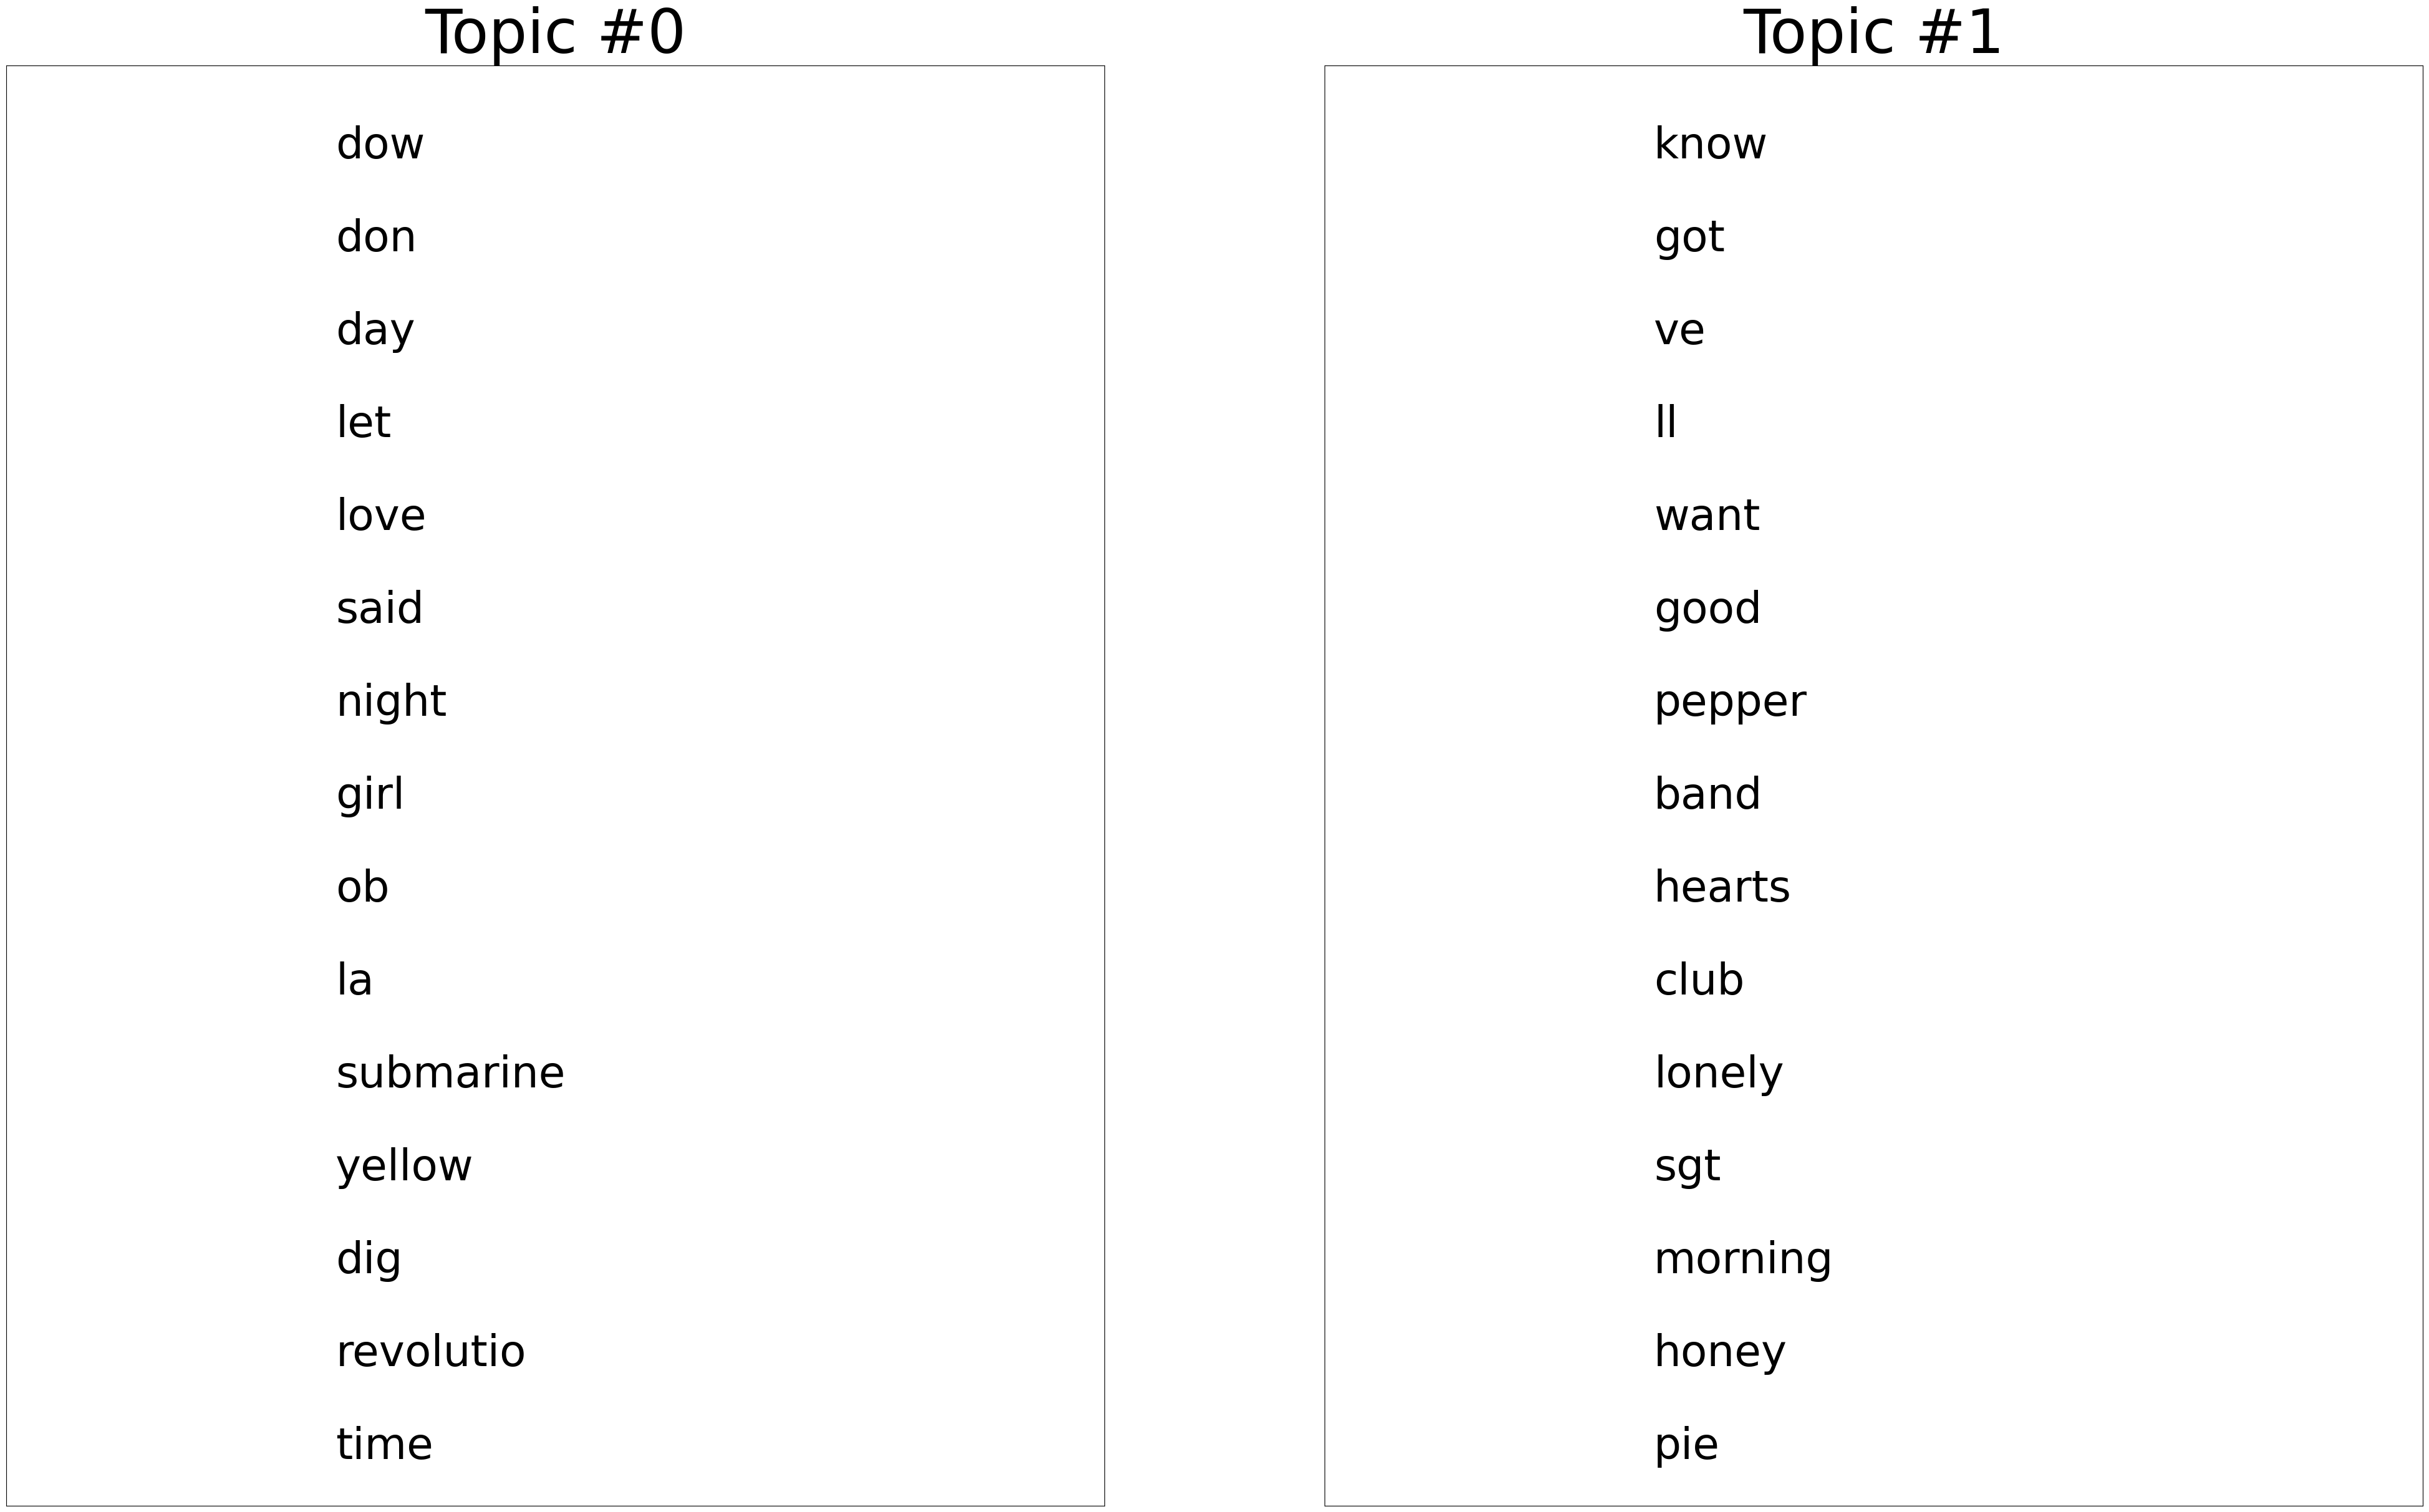

In [6]:
# Plot it!
plt.figure(figsize=(50,30))
word_topic = np.array(lda_model.components_)
word_topic = word_topic.transpose()

num_top_words = top_n
ColumnNames = song_titles_unlabeled.columns.tolist()
vocab_array = np.asarray(ColumnNames)

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t), size = 70)
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i -0.5, word, fontsize = 50)

plt.show()

LDA for Lyrics

In [12]:
client_id = "yxeLnXDdwoDJunEPDRUgYVmH-I703sGZKWGoCdKbFNupYKHugalkOVqtzh3aSe82"
client_secret = "zd3utRAeYAprwImrgEPERa6BPjNrJMOcg4ogsbTAR-uCoIoh9zu28ufhMVRYlBTpb8kSHkWK75LDrHSerdEOag"
client_access_token = "wVsdPF-_vbLLypQZ3qaR0EwytwJW2jKBsK-PoZwv6BDKQLDK0gkUwstOYuH-EDD2"

def request_song_info(artist_name, song_title):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': f'Bearer {client_access_token}'}
    search_url = base_url + '/search'
    params = {'q': f'{artist_name} {song_title}'}

    response = requests.get(search_url, params = params, headers = headers)
    return response

def request_song_url(artist_name, song_titles):
    # Input is song titles, want to find associated urls with each
    urls = []
    track_names = []

    for song in song_titles:
        #print(song)
        song = re.sub("´", "'", song)
        song = re.sub("  ", " ", song)
        response = request_song_info(artist_name, song)
        json = response.json()
    
        # Extract the first matching song URL
        hit = json['response']['hits'][0]['result']
        #print(hit)
        #print(hit['title'].lower())
        if (artist_name.lower() in hit['primary_artist']['name'].lower()):
            song_url = hit['url']
            urls.append(song_url)
            
            match = re.search(r'beatles-(.*?)-lyrics', song_url)
    
            if match:
                result = match.group(1) 
                track_names.append(result)
        
    # Return both the URL and the song title
    return [urls, track_names] 

# First want to only have songs that are composed by lennon or mccartney
os.chdir("C:/Users/maede/Downloads/Python/INFO5653/Project/Project/INFO5653_Project")
df = pd.read_csv("song_composer_singer.csv")
df.columns = ["Song", "Composer", "Singer"]
lennon_mccartney = df[df['Composer'].isin(["Lennon", "McCartney"])]

# Now want to match songs from this set to the lyrics pulled from genuis api
l_m_songs = list(lennon_mccartney['Song'])

# Composer list
l_m_composer = list(lennon_mccartney['Composer'])

# Find urls!
artist_name = "The Beatles"
[urls, song_titles] = request_song_url(artist_name, l_m_songs)

# Scrape lyrics from a Genius.com song URL
def scrape_song_lyrics(url):
    song = requests.get(url)
    html = BeautifulSoup(song.content, 'html.parser')
    lyrics_divs = html.find_all("div", {"data-lyrics-container": "true"})
    
    if lyrics_divs:
        lyrics = "\n".join(div.get_text(separator="\n") for div in lyrics_divs)
        # Remove identifiers like chorus, verse, etc
        lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics, flags=re.DOTALL).strip()
        
        # Remove empty lines
        lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])  
    else:
        print("Lyrics not found!")
        lyrics = ""
    
    return lyrics

def write_lyrics_to_corpus(urls, track_names, composer, path):
    for i in range(len(track_names)):
        # Get url and title
        url = urls[i]
        title = track_names[i]
        label = composer[i]
        title = re.sub(" ", "-", title)
        title = re.sub(r"\?", "", title)
        title = title.lower()
    
        # Create file, mypath, and filename
        file = str(label) + '-' + str(title) + ".txt"
        filename = mypath + "/" + file
    
        # Open file to write to
        my_file = open(filename, "w", encoding = "utf-8")
    
        # Find lyrics
        lyrics = scrape_song_lyrics(url)
        my_file.write(lyrics)
        my_file.close()

mypath = "C:/Users/maede/Downloads/Python/INFO5653/Project/Project/INFO5653_Project/Composer_Lyrics_Corpus"
write_lyrics_to_corpus(urls, song_titles, l_m_composer, mypath)

########## PART 3: USE CORPUS TO BUILD DATAFRAME ##########

# Path to corpus
path = "C:/Users/maede/Downloads/Python/INFO5653/Project/Project/INFO5653_Project/Composer_Lyrics_Corpus"

# Create file name
file_name_list = os.listdir(path)[1:]

# Initliaze empty lists that will be filled later with all file paths in corpus
complete_file_paths = [] 
list_file_names = []
    
for name in file_name_list:
    nextfile = path + "/" + name 
    complete_file_paths.append(nextfile) 
    nextnameL = name.split(".")
    list_file_names.append(nextnameL[0])

LDA for Lyrics

In [13]:
# USE COUNTVECTORIZOR AND LET MAX_FEATURES = 100

# Now we can use CountVectorizer 
my_vect = CountVectorizer(input = 'filename', stop_words = 'english', token_pattern=r'\b[a-zA-Z]{4,}\b', max_features = 100)
fit = my_vect.fit_transform(complete_file_paths)
column_names = my_vect.get_feature_names_out()

# Convert to dataframe
lyrics_df = pd.DataFrame(fit.toarray(),columns = column_names)

# Add labels using a dictionary
dict_labels = {}

for i in range(0, len(complete_file_paths)):
    dict_labels[i] = list_file_names[i].split("-")[0]

lyrics_df = lyrics_df.rename(dict_labels, axis = "index")
lyrics_df.index.name = "LABEL"

# Write dataframe to csv
lyrics_df.to_csv("paul_john_lyrics_corpus_count100.csv", index = True)

In [17]:
# Read in file
lyrics = pd.read_csv("paul_john_lyrics_corpus_count100.csv")

# Get labels and change to numbers
labels = lyrics['LABEL']

# Remove labels
lyrics_unlabeled = lyrics.drop("LABEL", axis = 1)

Topic 0:
[('love', 325.7454820956822), ('girl', 115.4460694696309), ('need', 109.22794066804045), ('little', 103.6179892410352), ('good', 97.28107287812979), ('know', 95.02720492320942), ('help', 93.94367806823655), ('gonna', 73.70788727447223), ('said', 73.16794038508965), ('away', 69.44170103996589), ('time', 65.20278575763557), ('children', 59.64813408234797), ('just', 57.779345922591986), ('come', 54.55974895280833), ('today', 49.35490066858906)]
Topic 1:
[('yellow', 160.95264362177232), ('submarine', 153.97472450731), ('know', 149.96430066663373), ('home', 127.26033384597275), ('mother', 111.64294106927791), ('road', 105.1677225769103), ('long', 93.09554740473654), ('honey', 60.61321581717388), ('time', 55.21955853383378), ('yeah', 46.04950891569749), ('going', 39.59673888855553), ('want', 29.715960529351136), ('better', 26.168012935192397), ('dance', 24.769216951774386), ('life', 24.251581976744998)]


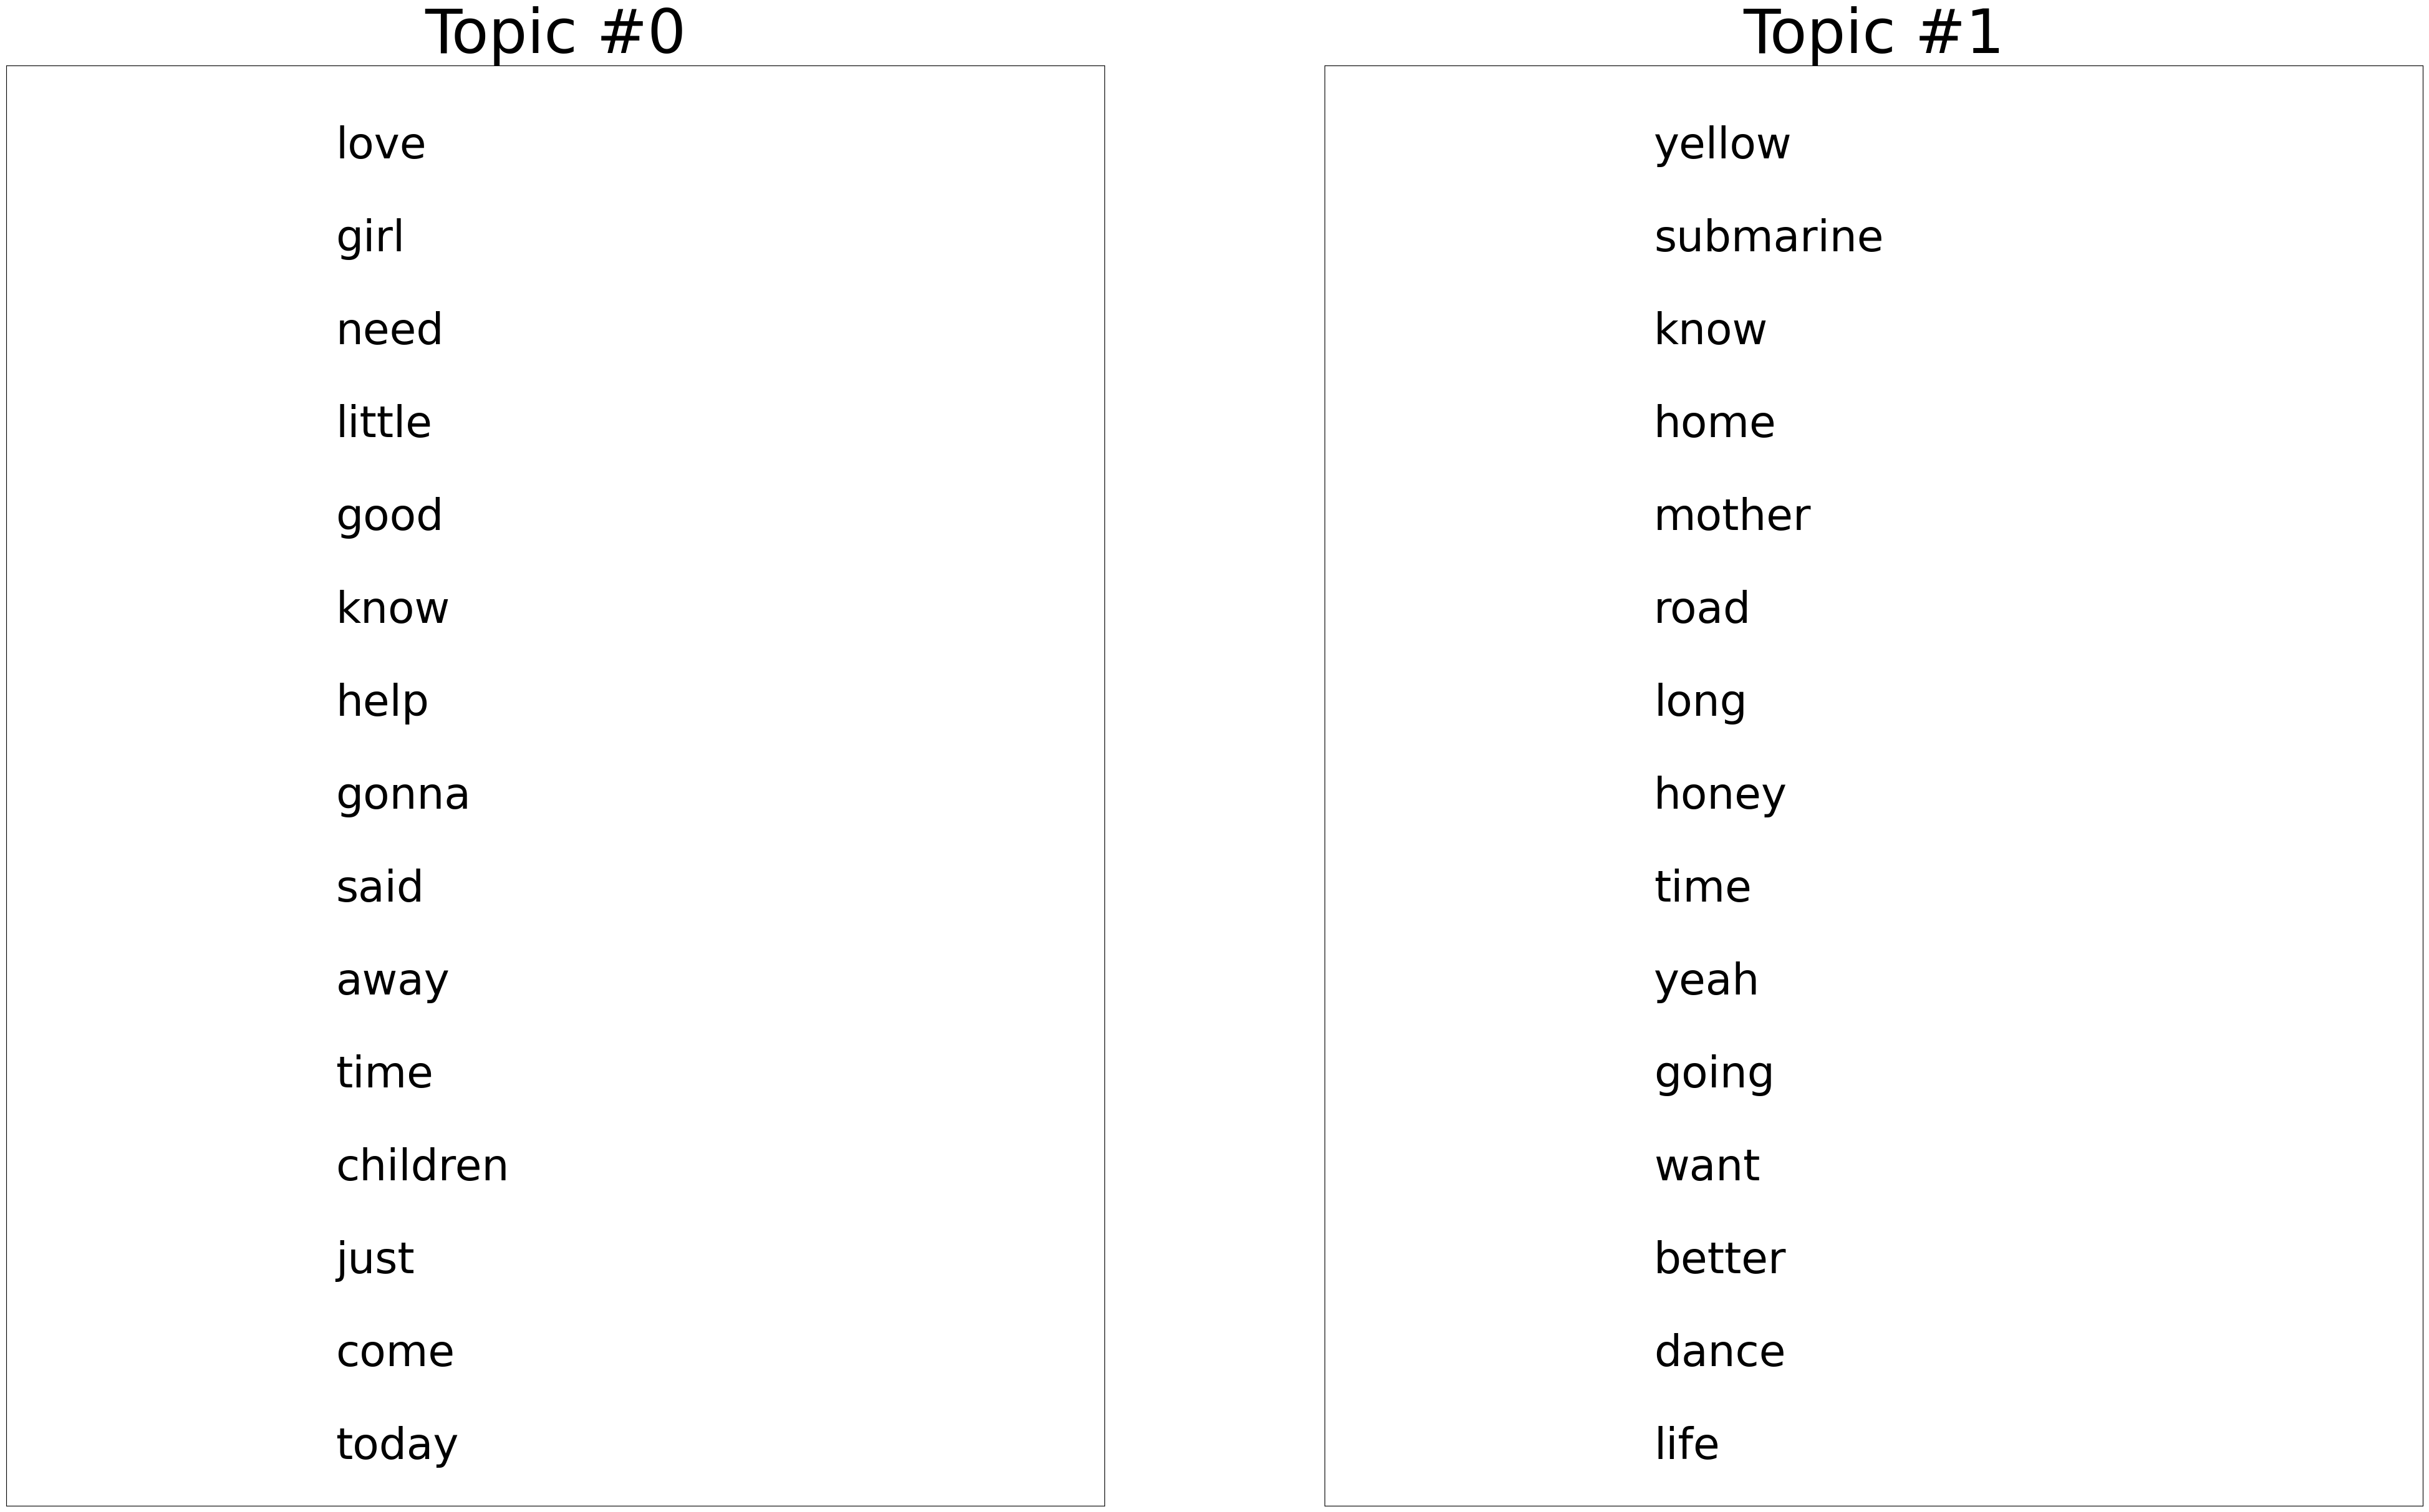

In [20]:
########## LDA Topics Modeling ##########
random.seed(1)
num_topics = 2
lda_model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100, learning_method = 'online')
   
lda_df = lda_model.fit_transform(lyrics_unlabeled)

def print_topics(model, vectorizer, top_n = 10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                    for i in topic.argsort()[:-top_n - 1:-1]])

top_n = 15
print_topics(lda_model, my_vect, top_n)

# Plot it!
plt.figure(figsize=(50,30))
word_topic = np.array(lda_model.components_)
word_topic = word_topic.transpose()

num_top_words = top_n
ColumnNames = lyrics_unlabeled.columns.tolist()
vocab_array = np.asarray(ColumnNames)

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t), size = 70)
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i -0.5, word, fontsize = 50)

plt.show()

LDA for Lyrics STEM

In [33]:
# STEMMING, CountVectorizer, max_features = 100
STEMMER = PorterStemmer()
def MY_STEMMER(str_input):
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    words = [word for word in words if len(word) >= 4]
    words = [STEMMER.stem(word) for word in words]
    return words
    
my_vect = CountVectorizer(input = 'filename', tokenizer = MY_STEMMER, max_features = 100)
fit = my_vect.fit_transform(complete_file_paths)
column_names = my_vect.get_feature_names_out()

# Convert to dataframe
lyrics_df = pd.DataFrame(fit.toarray(),columns = column_names)

# Add labels using a dictionary
dict_labels = {}

for i in range(0, len(complete_file_paths)):
    dict_labels[i] = list_file_names[i].split("-")[0]

lyrics_df = lyrics_df.rename(dict_labels, axis = "index")
lyrics_df.index.name = "Label"

# Write dataframe to csv
lyrics_df.to_csv("paul_john_lyrics_corpus_stem_count100.csv", index = True)

C:\Users\maede\New folder\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [34]:
# Read in file
lyrics = pd.read_csv("paul_john_lyrics_corpus_stem_count100.csv")

# Get labels and change to numbers
labels = lyrics['Label']

# Remove labels
lyrics_unlabeled = lyrics.drop("Label", axis = 1)

Topic 0:
[('love', 298.8883497903236), ('that', 179.74224884185637), ('will', 145.68488203068245), ('home', 127.31048708942583), ('when', 122.41686518439101), ('girl', 120.5307689478593), ('what', 113.15811445040963), ('your', 98.700476851149), ('time', 89.78302579123623), ('know', 86.99849321003732), ('need', 86.75429457599243), ('back', 79.47759904642231), ('yeah', 75.05408425689419), ('said', 73.17281402564771), ('have', 71.96828758384368)]
Topic 1:
[('know', 164.4767814052384), ('yellow', 160.95578703254714), ('submarin', 159.8776395986956), ('your', 148.04653674943177), ('with', 121.02340220328398), ('mother', 111.63198334702759), ('littl', 103.55650703625497), ('from', 101.5301593235862), ('friend', 97.57668184441266), ('good', 96.06611441532738), ('help', 95.52524764279654), ('should', 86.51944284518615), ('down', 63.61102923205203), ('long', 54.916379405799596), ('sing', 43.736177712047045)]


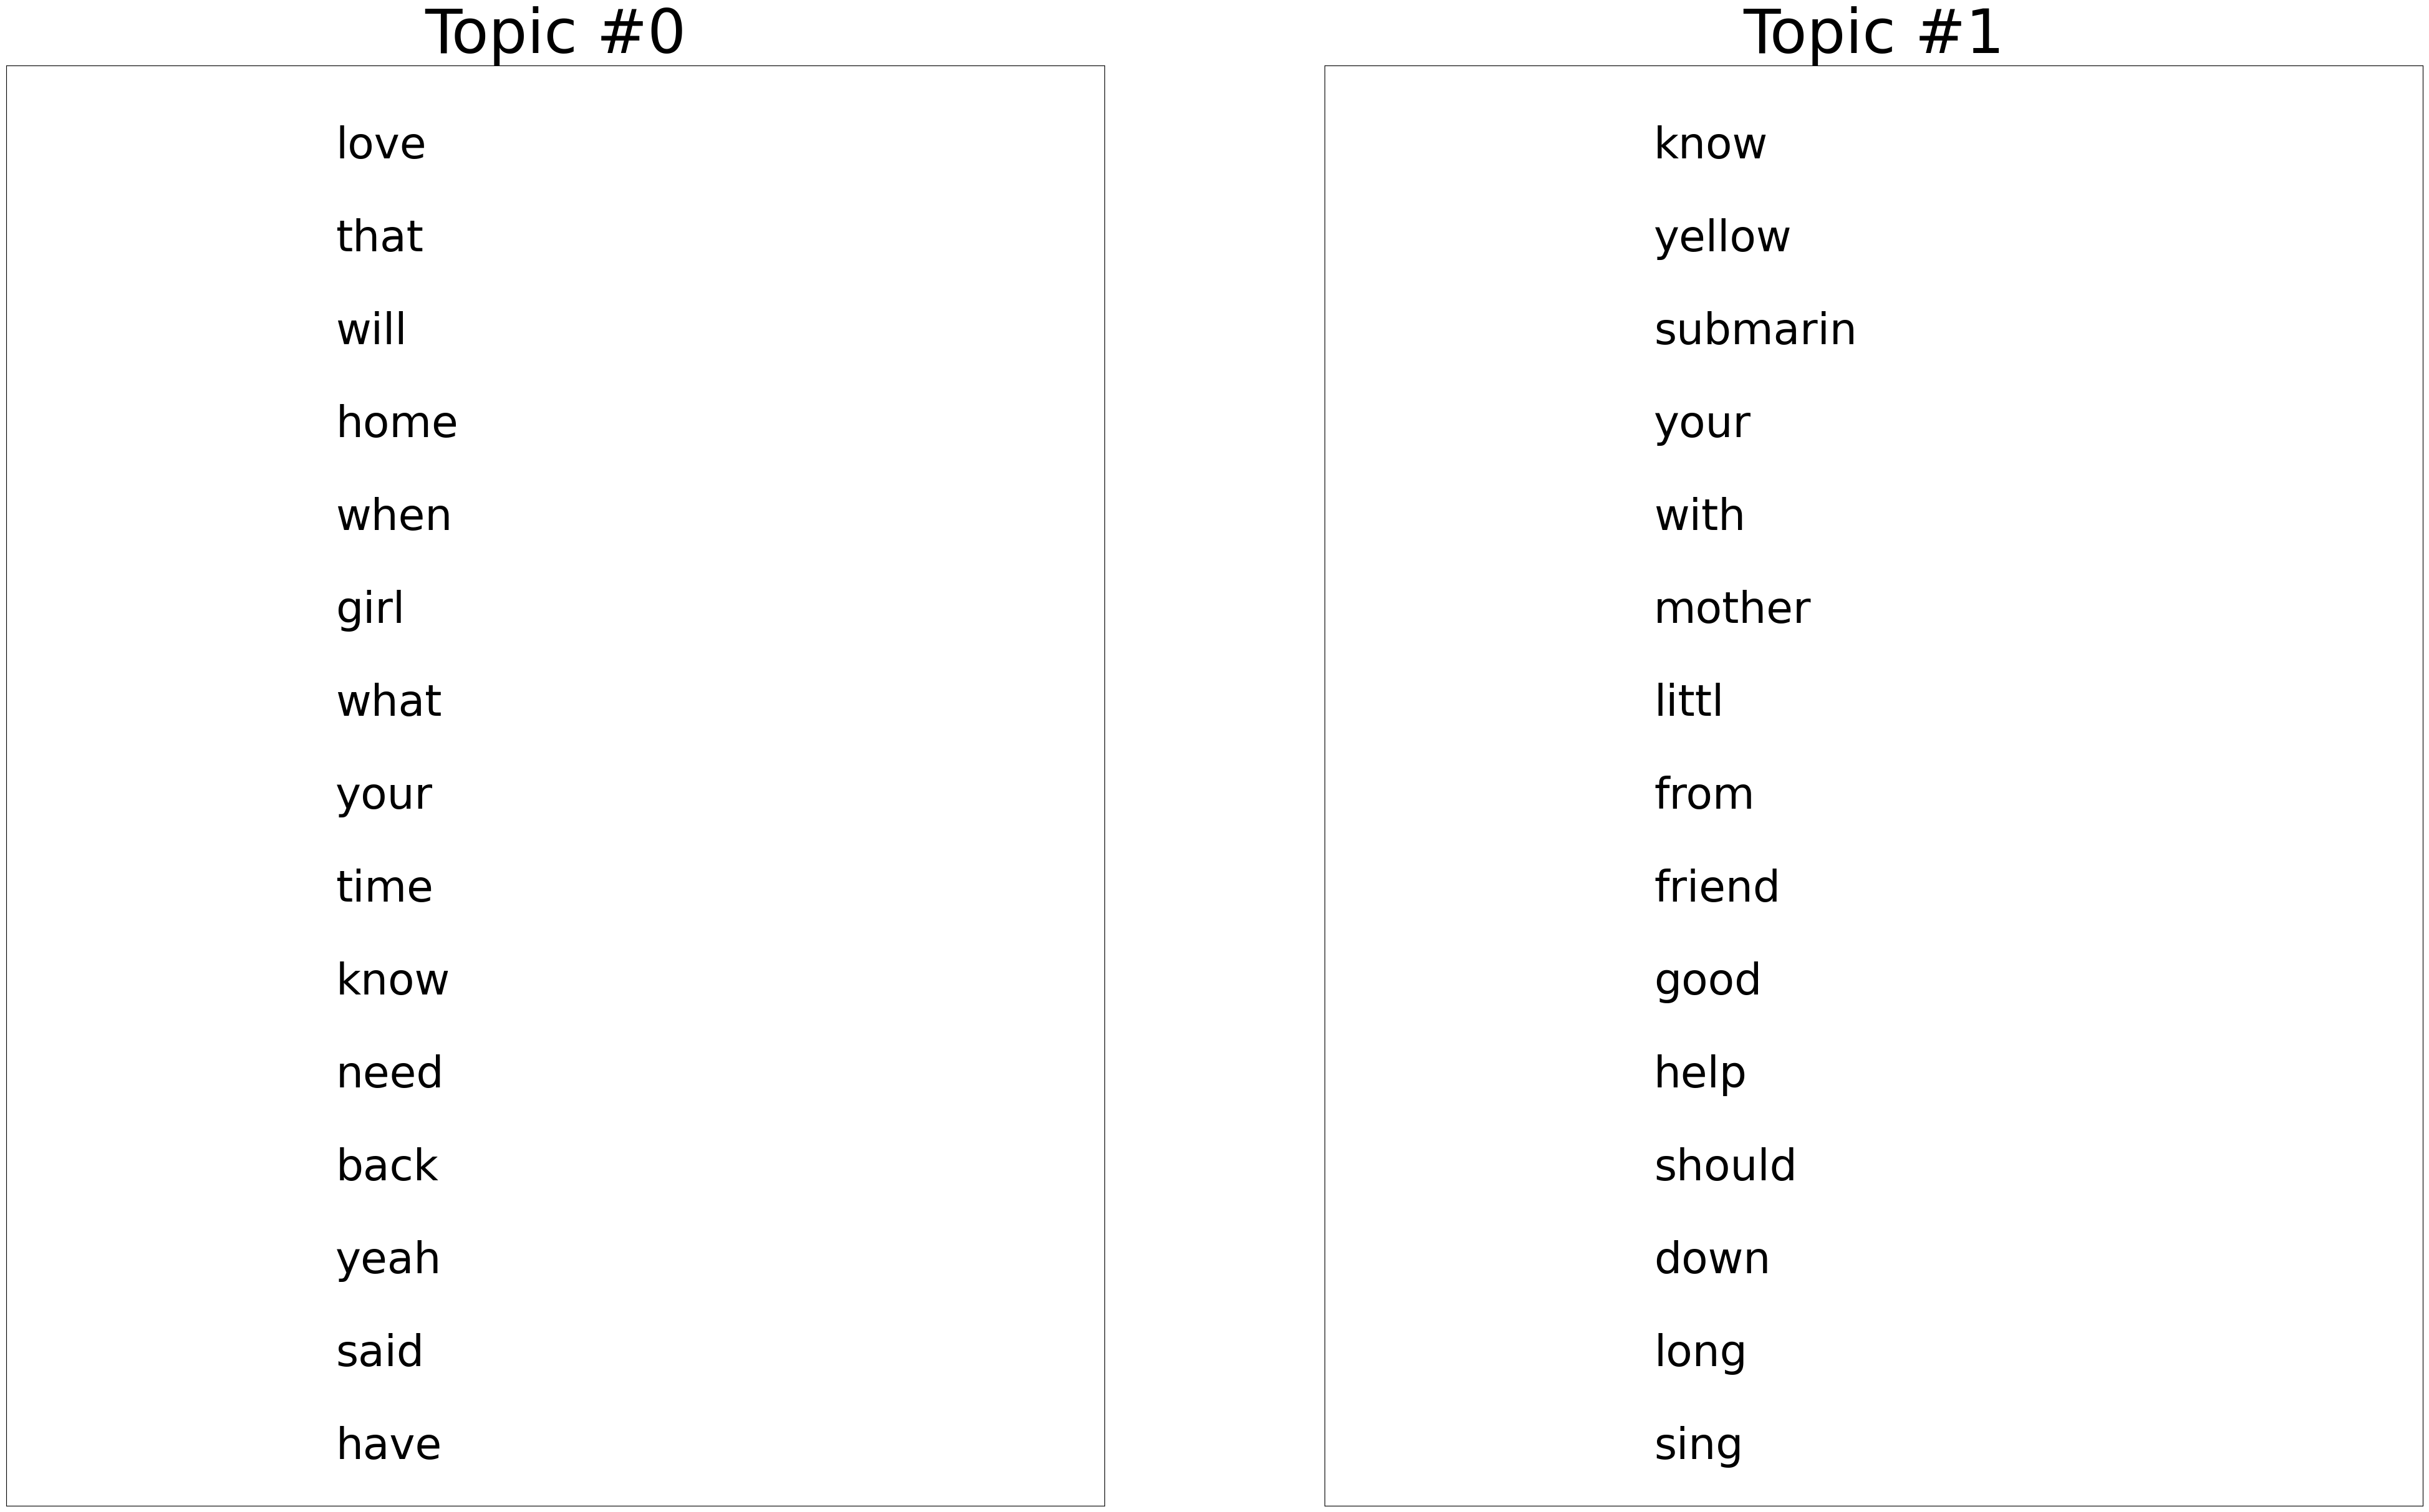

In [35]:
########## LDA Topics Modeling ##########
random.seed(1)
num_topics = 2
lda_model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100, learning_method = 'online')
   
lda_df = lda_model.fit_transform(lyrics_unlabeled)

def print_topics(model, vectorizer, top_n = 10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                    for i in topic.argsort()[:-top_n - 1:-1]])

top_n = 15
print_topics(lda_model, my_vect, top_n)

# Plot it!
plt.figure(figsize=(50,30))
word_topic = np.array(lda_model.components_)
word_topic = word_topic.transpose()

num_top_words = top_n
ColumnNames = lyrics_unlabeled.columns.tolist()
vocab_array = np.asarray(ColumnNames)

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t), size = 70)
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i -0.5, word, fontsize = 50)

plt.show()

LDA for Lyrics LEM

In [36]:
# LEMMING, CountVectorizer, max_features = 100
LEMMER = WordNetLemmatizer() 

def MY_LEMMER(str_input):
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    words = [word for word in words if len(word) >= 4] 
    words = [LEMMER.lemmatize(word) for word in words]
    return words
    
my_vect = CountVectorizer(input = 'filename', tokenizer = MY_LEMMER, max_features = 100)
fit = my_vect.fit_transform(complete_file_paths)
column_names = my_vect.get_feature_names_out()

# Convert to dataframe
lyrics_df = pd.DataFrame(fit.toarray(),columns = column_names)

# Add labels using a dictionary
dict_labels = {}

for i in range(0, len(complete_file_paths)):
    dict_labels[i] = list_file_names[i].split("-")[0]

lyrics_df = lyrics_df.rename(dict_labels, axis = "index")
lyrics_df.index.name = "Label"

# Write dataframe to csv
lyrics_df.to_csv("paul_john_lyrics_corpus_lem_count100.csv", index = True)

C:\Users\maede\New folder\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [38]:
# Read in file
lyrics = pd.read_csv("paul_john_lyrics_corpus_lem_count100.csv")

# Get labels and change to numbers
labels = lyrics['Label']

# Remove labels
lyrics_unlabeled = lyrics.drop("Label", axis = 1)

Topic 0:
[('love', 252.30735518024017), ('yellow', 160.95065175889283), ('submarine', 159.87765176826028), ('will', 131.70638455314574), ('road', 103.59968949189793), ('good', 95.92866455569603), ('that', 82.33377581963192), ('when', 80.30188954907578), ('need', 66.78833489409386), ('child', 61.24678462534802), ('girl', 53.5200229691861), ('still', 52.43813209965478), ('only', 49.45652277579245), ('give', 47.61964184588556), ('said', 47.205410225307745)]
Topic 1:
[('know', 234.46525201668942), ('your', 212.02725782358343), ('with', 160.14670548852934), ('what', 139.60411201884605), ('that', 136.30405302725848), ('should', 129.8816287071524), ('home', 127.2571487998074), ('mother', 111.65249573658836), ('from', 106.33634890711858), ('little', 103.64556587561151), ('time', 97.24301993888298), ('help', 95.0209744962413), ('long', 93.43034206112549), ('friend', 91.02305097943685), ('yeah', 79.76832660221346)]


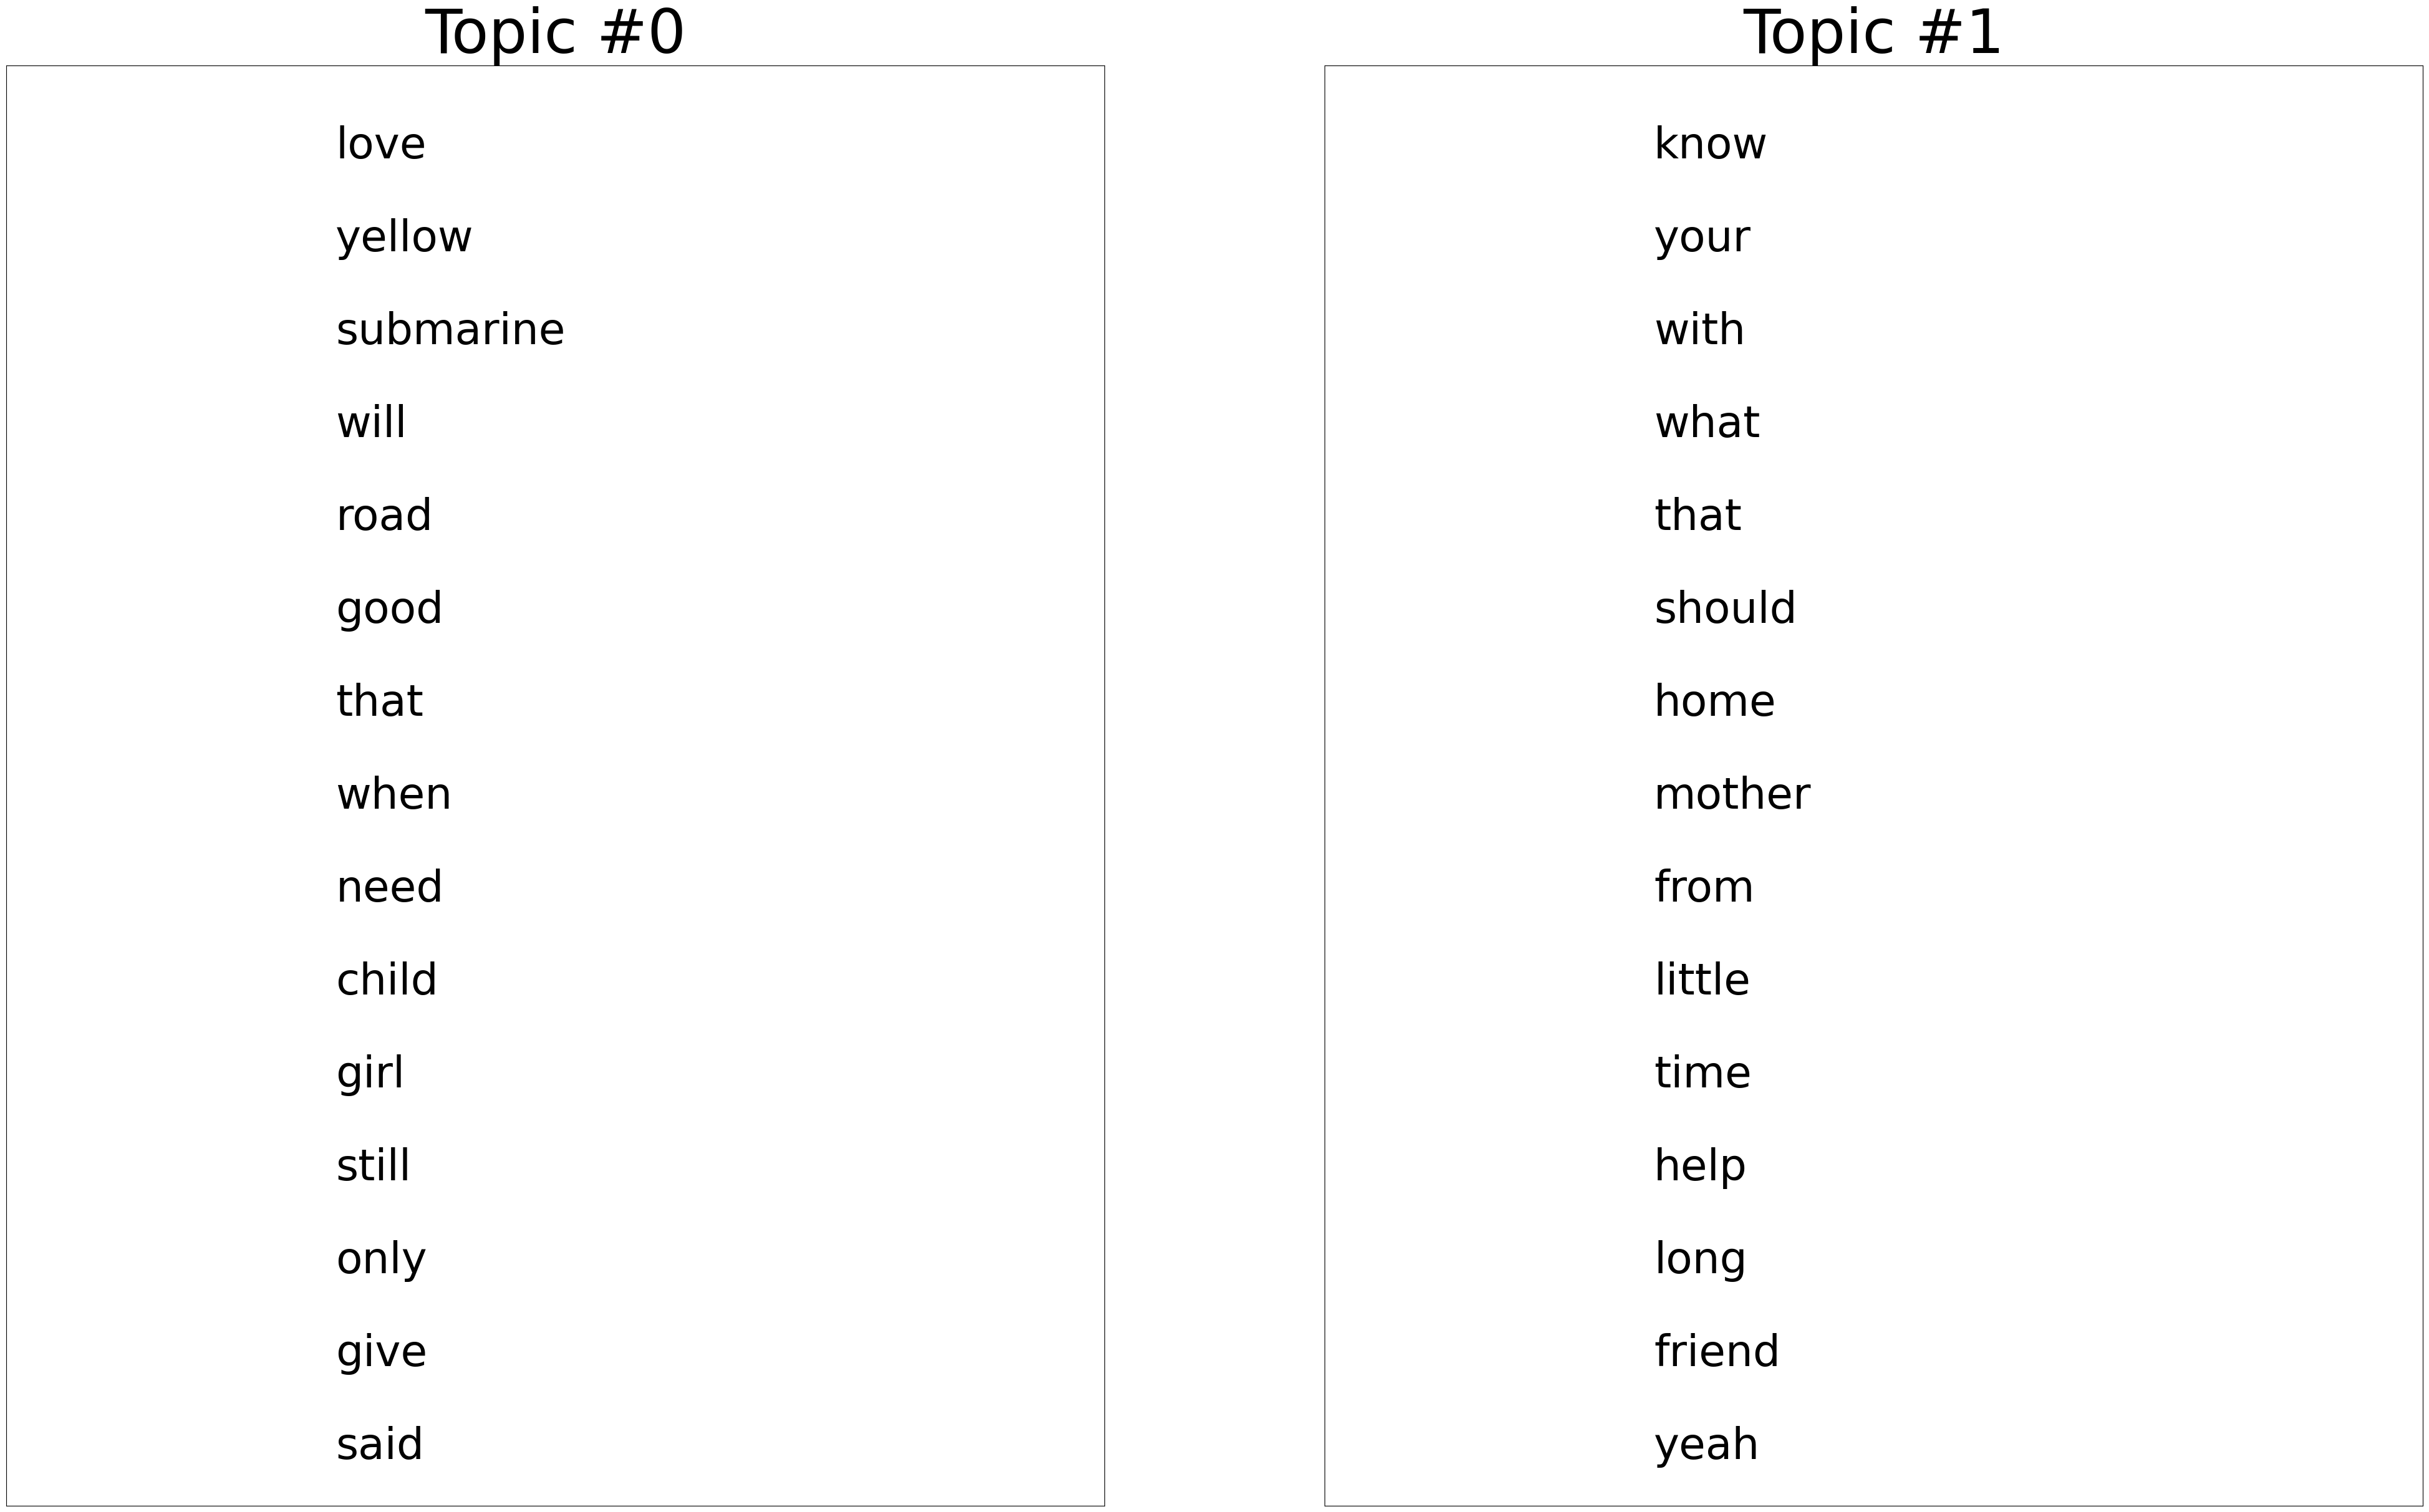

In [40]:
########## LDA Topics Modeling ##########
random.seed(1)
num_topics = 2
lda_model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100, learning_method = 'online')
   
lda_df = lda_model.fit_transform(lyrics_unlabeled)

def print_topics(model, vectorizer, top_n = 10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                    for i in topic.argsort()[:-top_n - 1:-1]])

top_n = 15
print_topics(lda_model, my_vect, top_n)

# Plot it!
plt.figure(figsize=(50,30))
word_topic = np.array(lda_model.components_)
word_topic = word_topic.transpose()

num_top_words = top_n
ColumnNames = lyrics_unlabeled.columns.tolist()
vocab_array = np.asarray(ColumnNames)

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t), size = 70)
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i -0.5, word, fontsize = 50)

plt.show()